# Data exploration and validation

## Load and inspect the dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns


path = kagglehub.dataset_download("patelris/crop-yield-prediction-dataset")
df = pd.read_csv(path + '/yield_df.csv', index_col=0)
df.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [4]:
df.describe()

,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


In [5]:
df.nunique()

Area                               101
Item                                10
Year                                23
hg/ha_yield                      11514
average_rain_fall_mm_per_year      100
pesticides_tonnes                 1673
avg_temp                          1831
dtype: int64

### Column conversion

As we can see from the previous cells, there are categorical (`Area` and `Item`) and numerical columns. For the categorical values to be used corectly we need to convert them into numerical value (`OneHotEncoding` or `OrdinalEncoding`) to actually use them in prediction.

## Analyze and visualize features

### Target variable

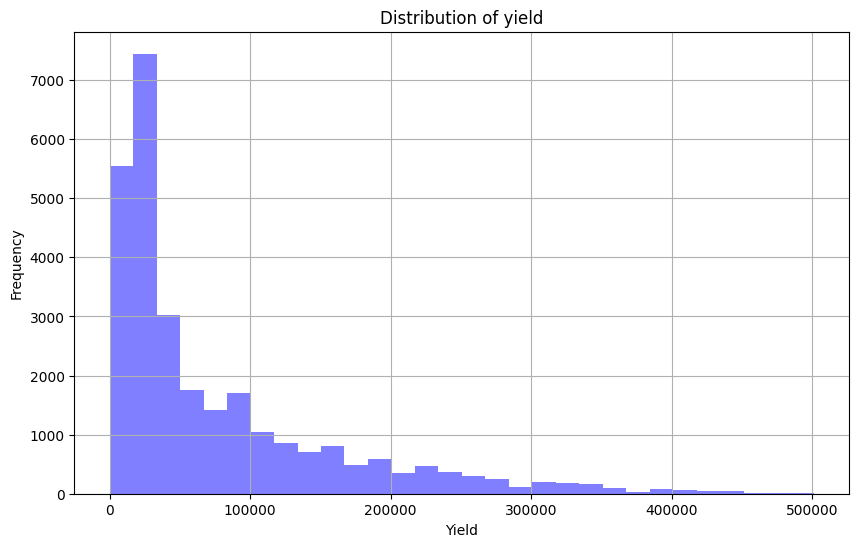

In [6]:
plt.figure(figsize=(10, 6))
df['hg/ha_yield'].hist(bins=30, alpha=.5, color='blue')
plt.title('Distribution of yield')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()

Distribution of yield appears to be **concentrated among lower values** and is not homogeneous.

---
### Numerical features

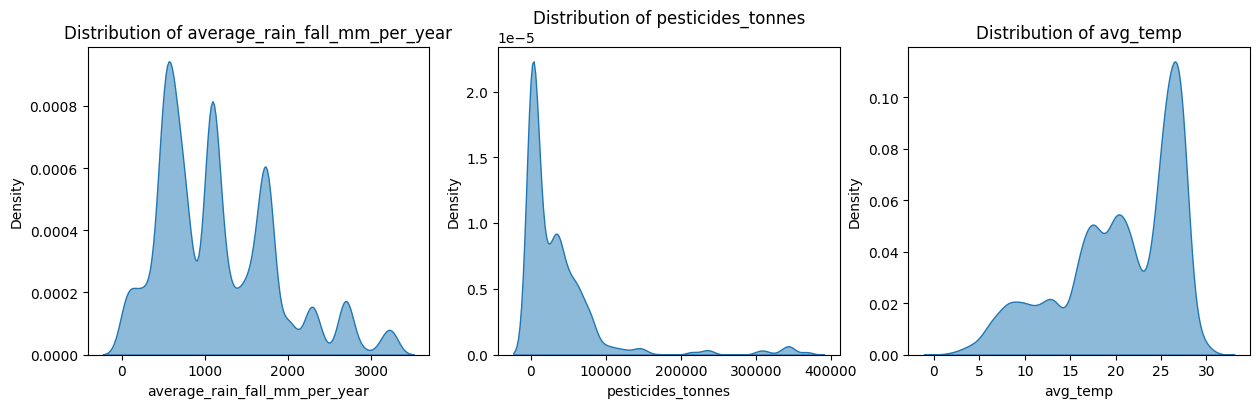

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
cols = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
for idx, col in enumerate(cols):
    sns.kdeplot(df[col], ax=axs[idx], fill=True, alpha=0.5)
    axs[idx].set_title('Distribution of ' + col)
plt.show()

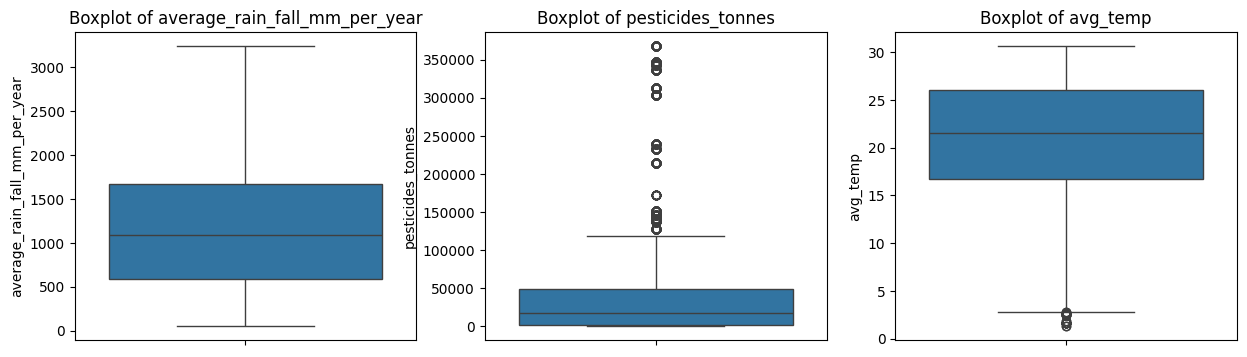

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(cols):
    sns.boxplot(df[col], ax=axs[idx])
    axs[idx].set_title('Boxplot of ' + col)
plt.show()

Distribution of numerical variables is again **not homogeneous** as some of them have a higher density towards lower values (`pesticides_tonnes` and `avg_rain_fall_mm_per_year`) while others towards higher values (`avg_temp`).  
The boxplots show that pesticides data contains some outliers as well for the average temperature.

---
### Categorical features

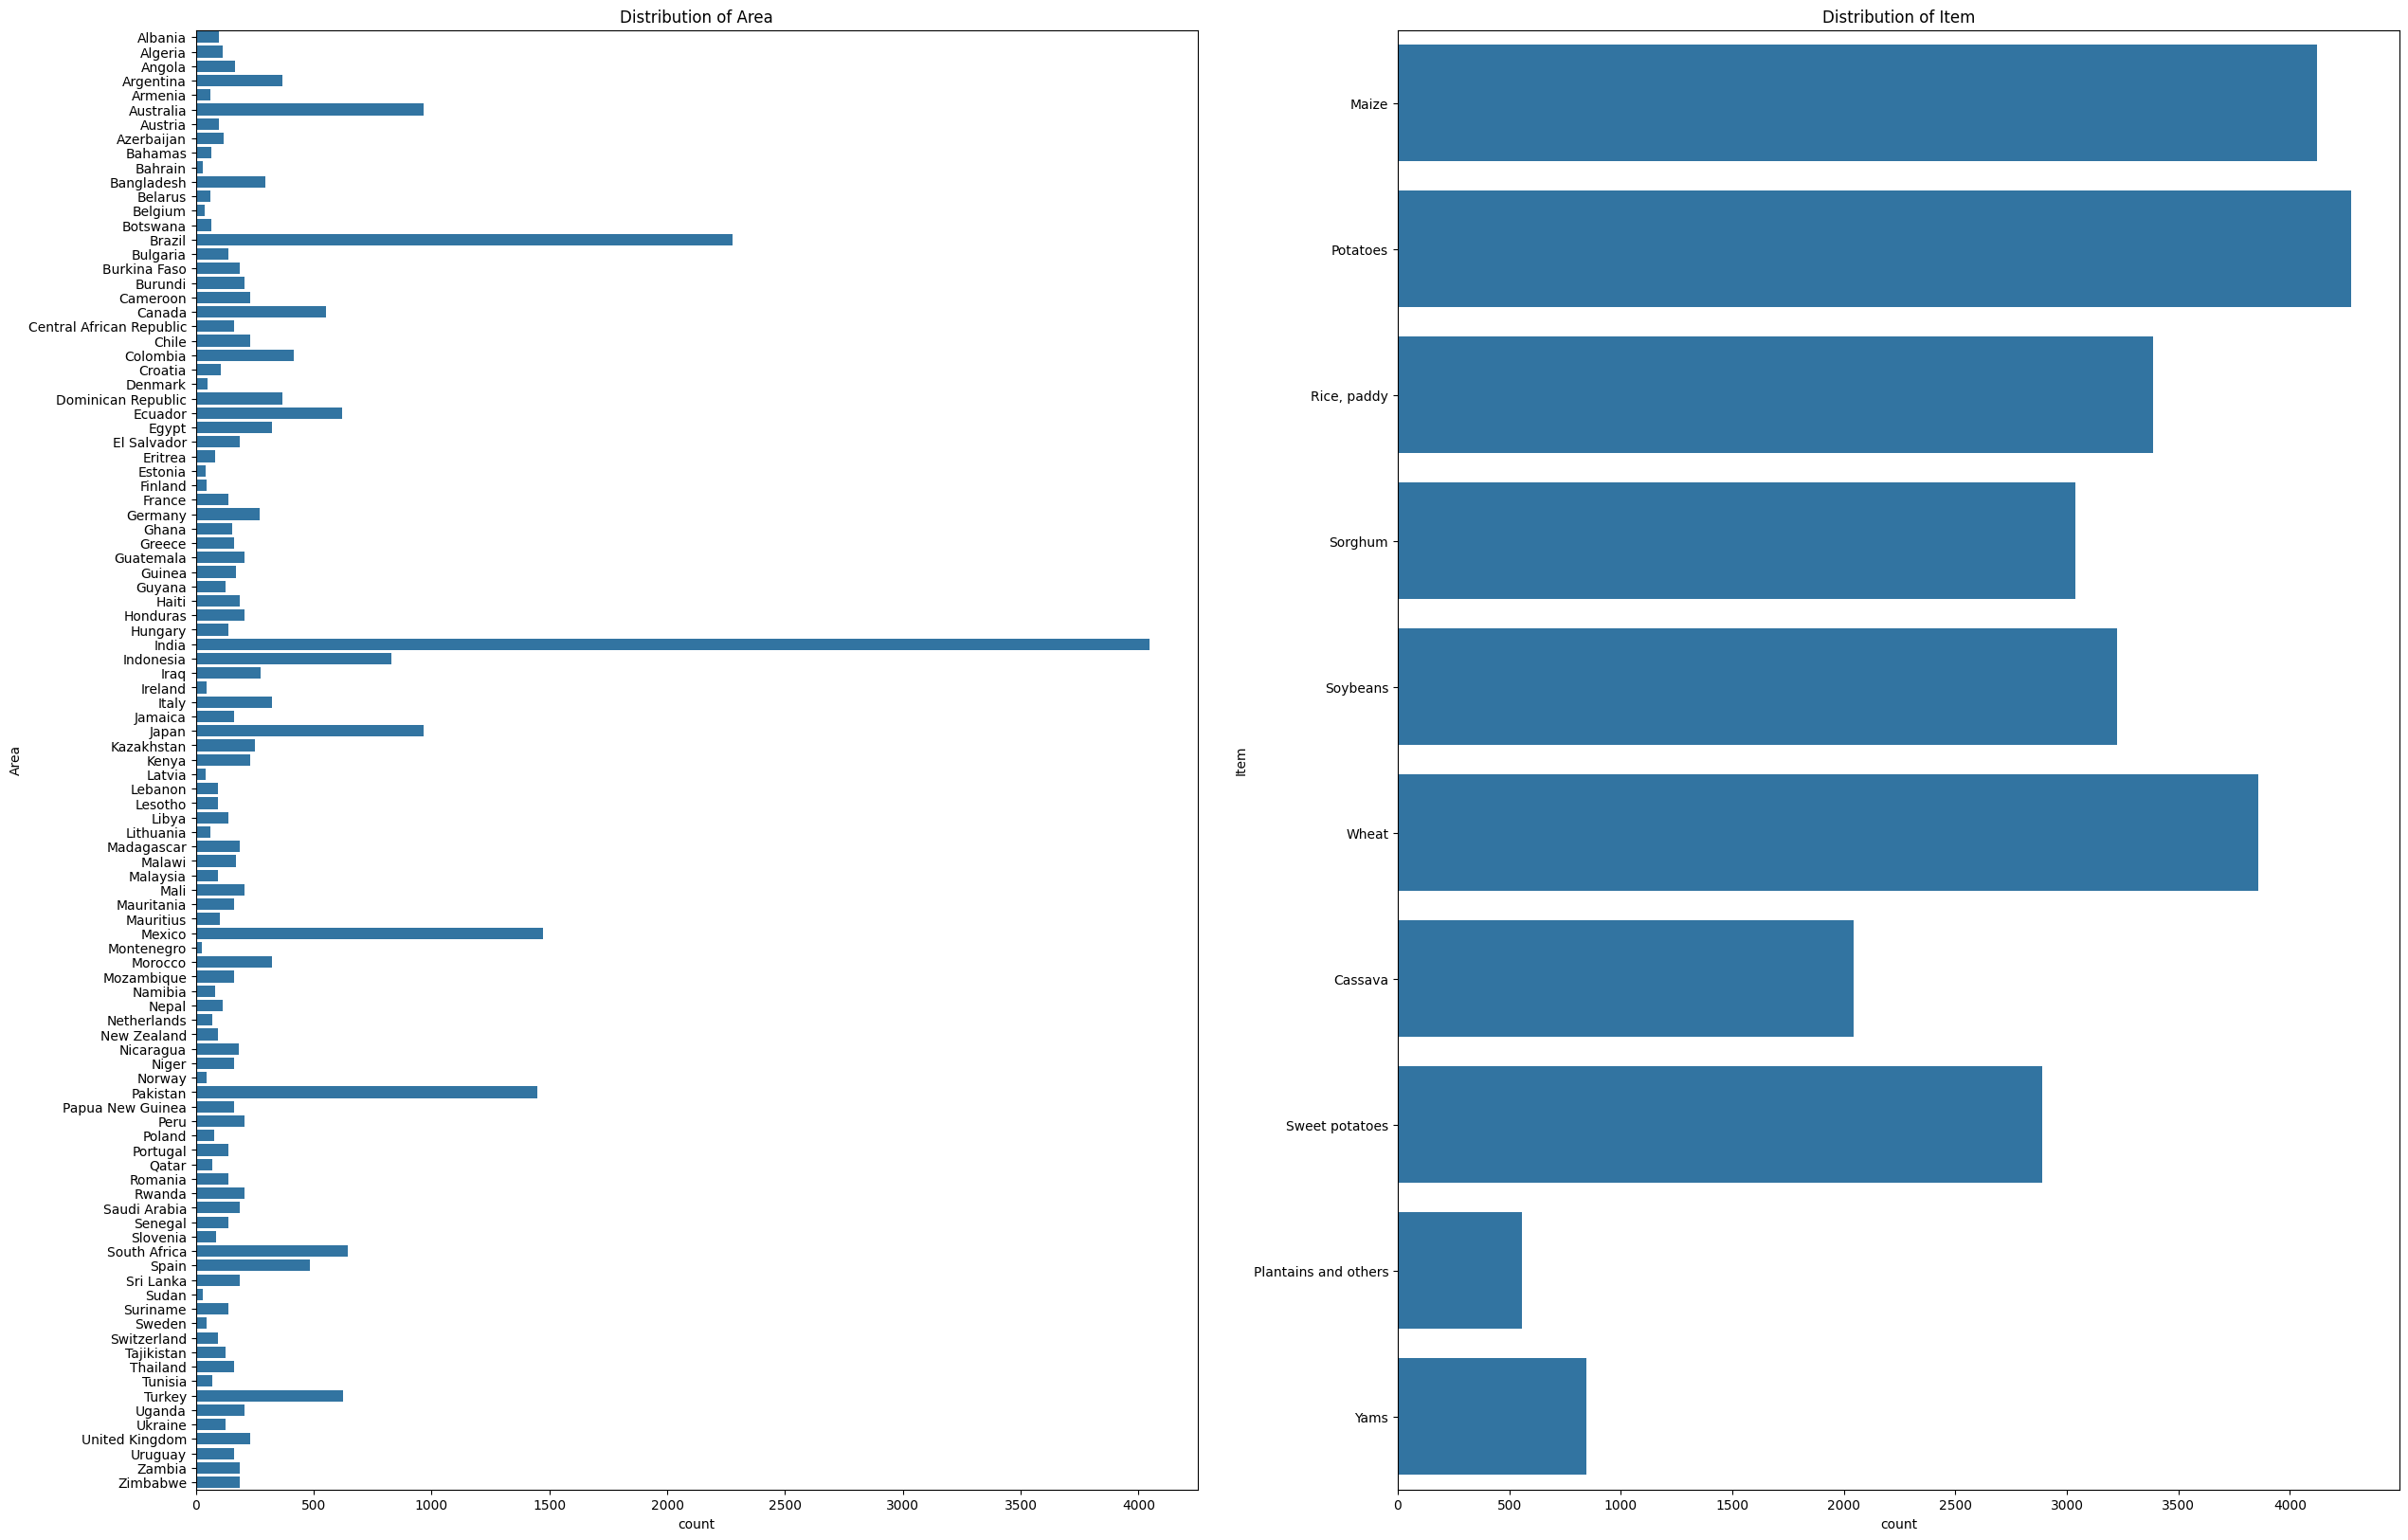

In [9]:
cols = ['Area', 'Item']
fig, axs = plt.subplots(1, 2, figsize=(30, 20))
for idx, col in enumerate(cols):
    sns.countplot(y=col, data=df, ax=axs[idx])
    axs[idx].set_title('Distribution of ' + col)
plt.show()

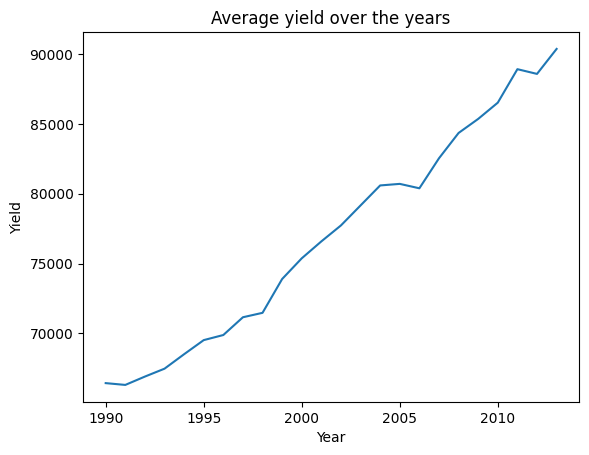

In [10]:
df.groupby(['Year'])['hg/ha_yield'].mean().plot()
plt.title('Average yield over the years')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.show()

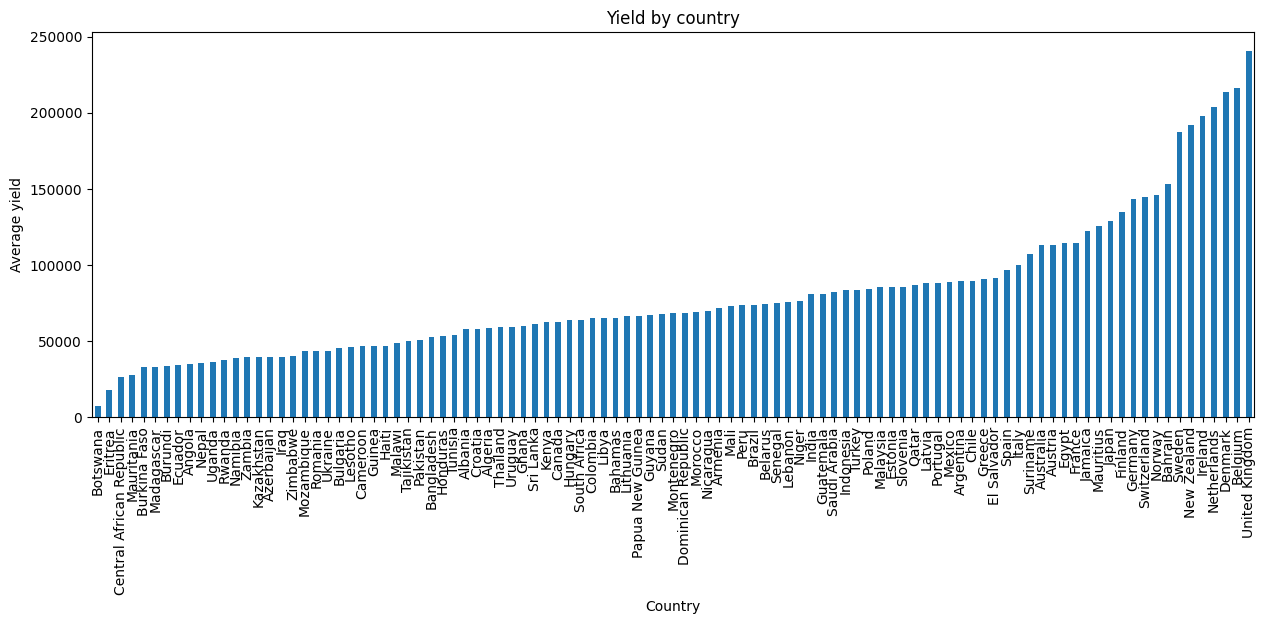

In [11]:
df.groupby('Area')[
    'hg/ha_yield'].mean().sort_values().plot(kind='bar', figsize=(15, 5))
plt.title('Yield by country')
plt.xlabel('Country')
plt.ylabel('Average yield')
plt.show()

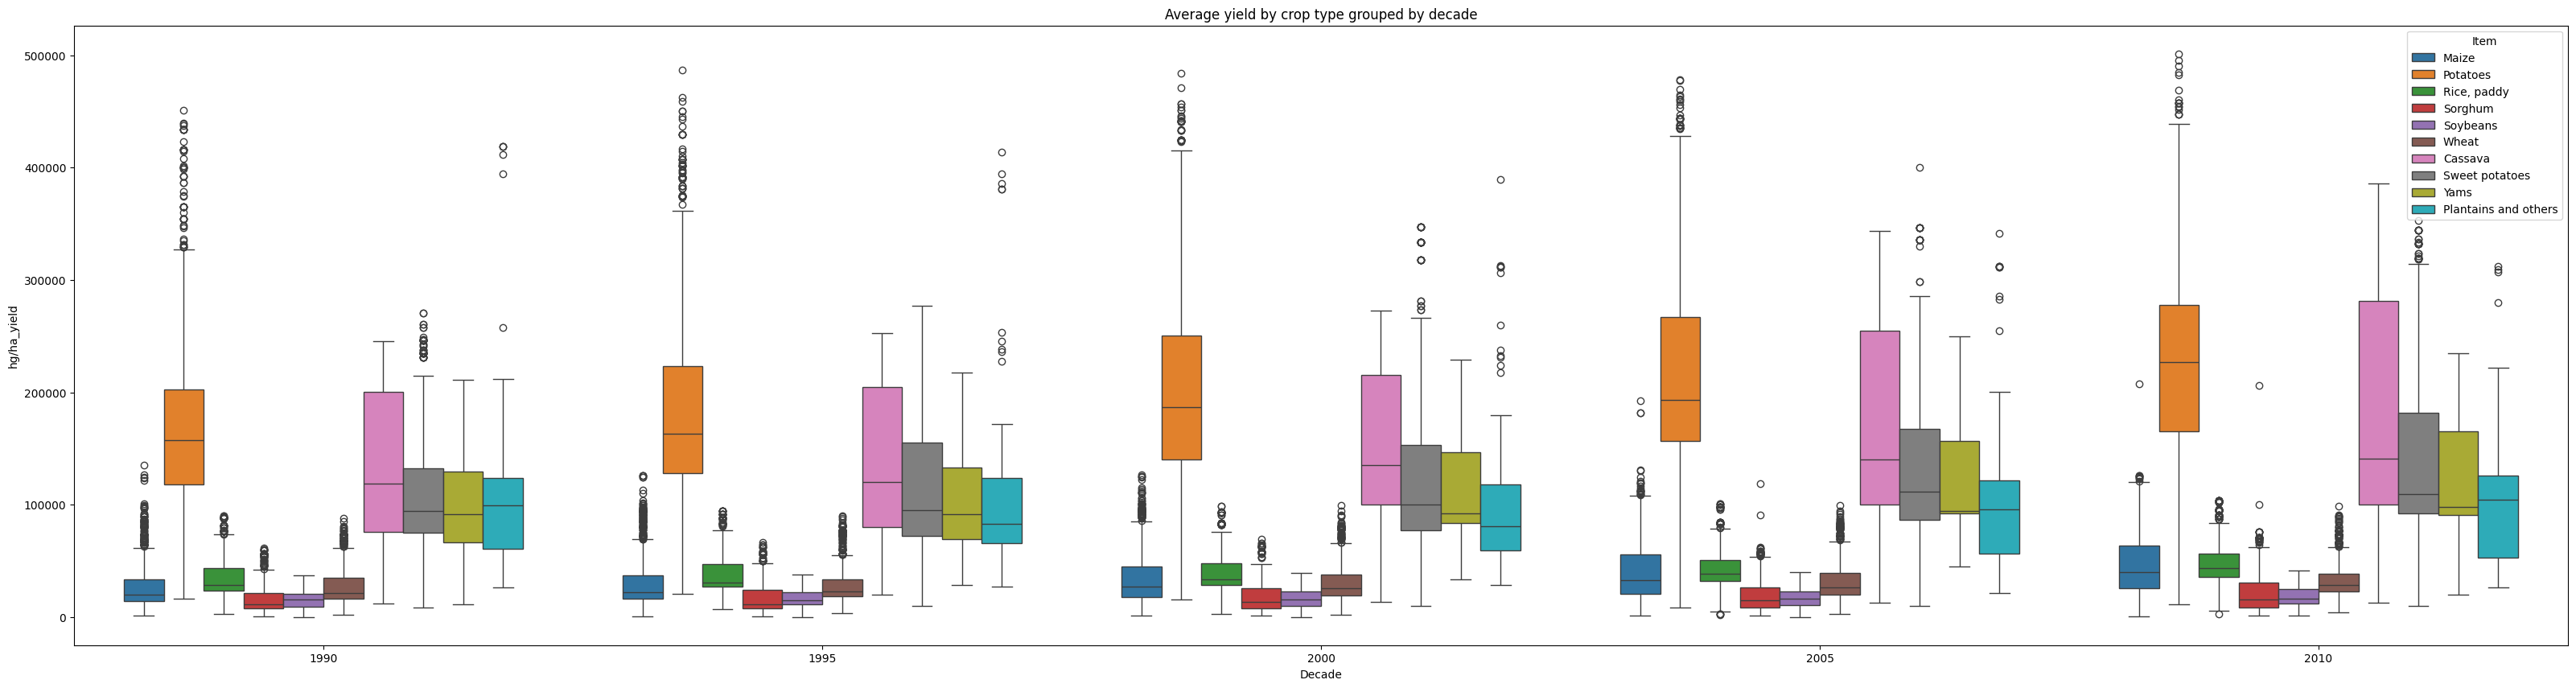

In [12]:
plt.figure(figsize=(40, 10))
df['Decade'] = df['Year'].apply(lambda x: int(x/5)*5)
sns.boxplot(data=df, x='Decade', y='hg/ha_yield', hue='Item')
plt.title('Average yield by crop type grouped by decade')
plt.show()

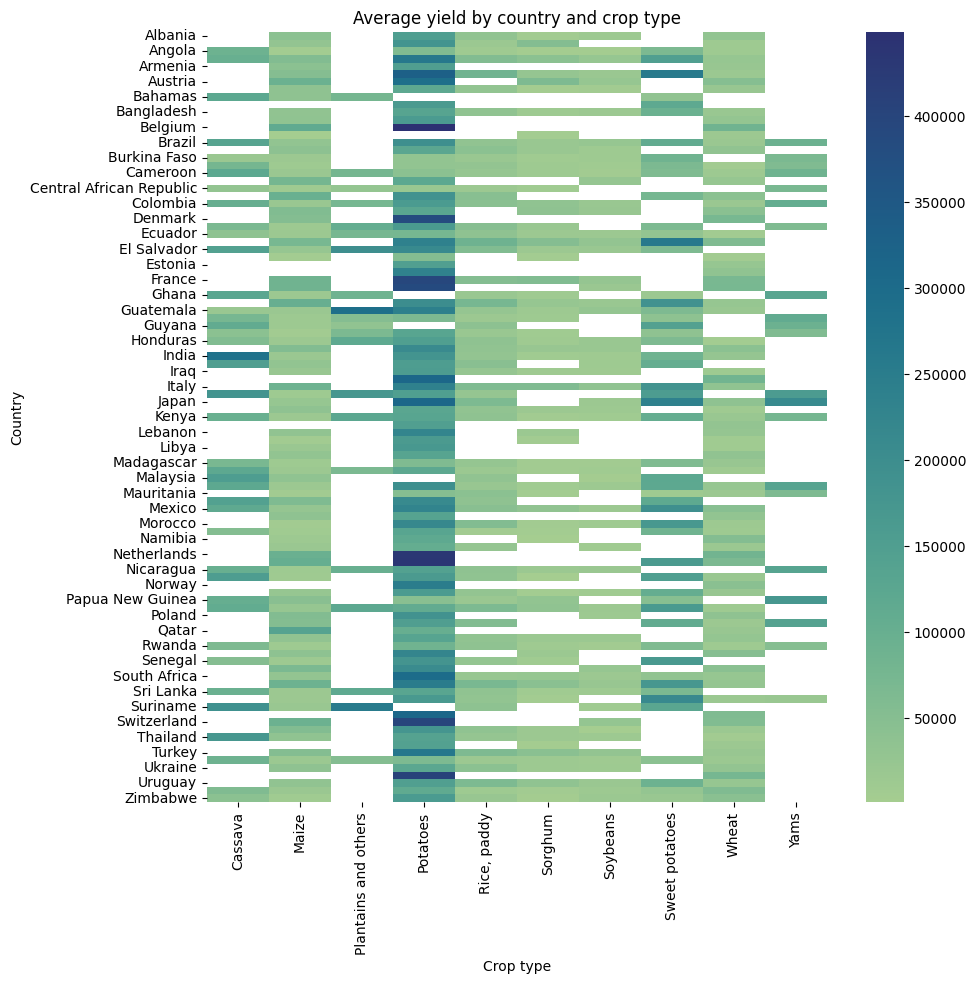

In [13]:
pivot_country_item = df.pivot_table(
    values='hg/ha_yield', index='Area', columns='Item', aggfunc='mean')
plt.figure(figsize=(10, 10))
sns.heatmap(pivot_country_item, annot=False, cmap='crest')
plt.title('Average yield by country and crop type')
plt.xlabel('Crop type')
plt.ylabel('Country')
plt.show()

Regarding the `Area` variable, we see that there are **countries that appear with much more frequency** than others while for the `Item` variable we see **more homogeneity** in references to crop items.


We see **positive correlation** between **time** and **yield** and also some correlation between country and yield, as **some countries have higher yields than others**.  
Boxplots also show highlight that information, and identify some **outliers** that maybe will require to be treated. The boxplots also show the fact that **different crop types have different yield**.  
We can see again in then heatmap that some items (_potatoes_) have higher yield overall, across various countries and that crop items are not cultivated everyhwere.

---
### Correlation analysis

In [14]:
grouped_crops = df.groupby('Item')
correlation_by_crop = grouped_crops[['average_rain_fall_mm_per_year',
                                     'avg_temp', 'pesticides_tonnes', 'hg/ha_yield']].corr().round(3)
correlation_by_crop

average_rain_fall_mm_per_year  \
Item                                                                                
Cassava              average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.182   
                     pesticides_tonnes                                      0.021   
                     hg/ha_yield                                           -0.193   
Maize                average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.333   
                     pesticides_tonnes                                      0.164   
                     hg/ha_yield                                           -0.179   
Plantains and others average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.136   
                     pesticides_tonnes                                      0.616   
                     hg/ha_yield                                            0.056   
Potatoes             average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.281   
                     pesticides_tonnes                                      0.191   
                     hg/ha_yield                                           -0.125   
Rice, paddy          average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.345   
                     pesticides_tonnes                                      0.139   
                     hg/ha_yield                                           -0.133   
Sorghum              average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.298   
                     pesticides_tonnes                                      0.270   
                     hg/ha_yield                                           -0.029   
Soybeans             average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.383   
                     pesticides_tonnes                                      0.179   
                     hg/ha_yield                                           -0.026   
Sweet potatoes       average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.210   
                     pesticides_tonnes                                      0.110   
                     hg/ha_yield                                           -0.223   
Wheat                average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.165   
                     pesticides_tonnes                                      0.340   
                     hg/ha_yield                                           -0.068   
Yams                 average_rain_fall_mm_per_year                          1.000   
                     avg_temp                                               0.033   
                     pesticides_tonnes                                      0.175   
                     hg/ha_yield                                            0.207   

                                                    avg_temp  \
Item                                                           
Cassava              average_rain_fall_mm_per_year     0.182   
                     avg_temp                          1.000   
                     pesticides_tonnes                -0.152   
                     hg/ha_yield                       0.354   
Maize                average_rain_fall_mm_per_year     0.333   
                     avg_temp    

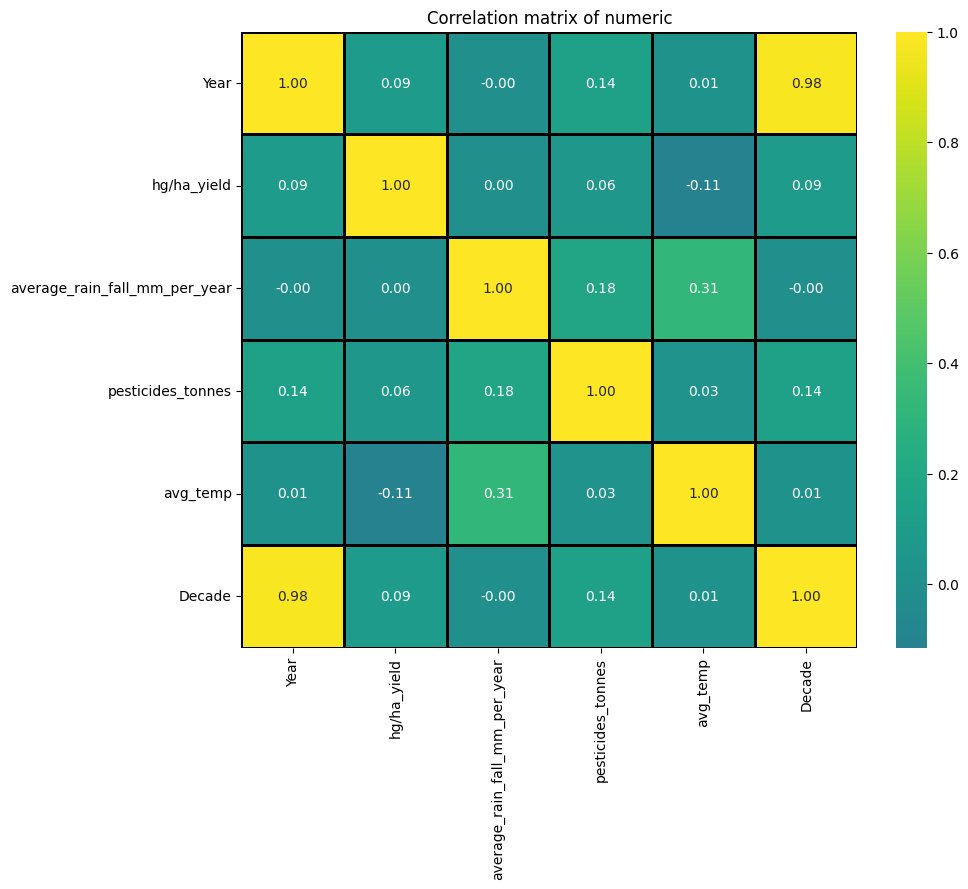

In [15]:
df_corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, center=0, linewidths=2,
            linecolor='black', square=True, fmt='.2f', cmap='viridis')
plt.title('Correlation matrix of numeric')
plt.show()

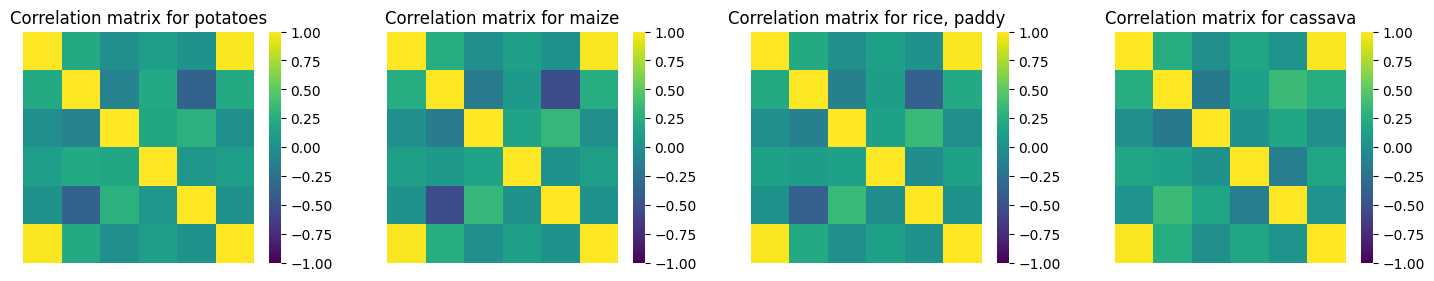

In [42]:
items = ['Potatoes', 'Maize', 'Rice, paddy', 'Cassava']
fig, axs = plt.subplots(1, 4, figsize=(18, 3))
for idx, item in enumerate(items):
    grouped = grouped_crops.get_group(item)
    group_corr = grouped.corr(numeric_only=True)
    sns.heatmap(group_corr, center=0, vmin=-1, vmax=1, square=True,
                cmap='viridis', ax=axs[idx], xticklabels=False, yticklabels=False)
    axs[idx].set_title(f'Correlation matrix for {item.lower()}')
plt.show()

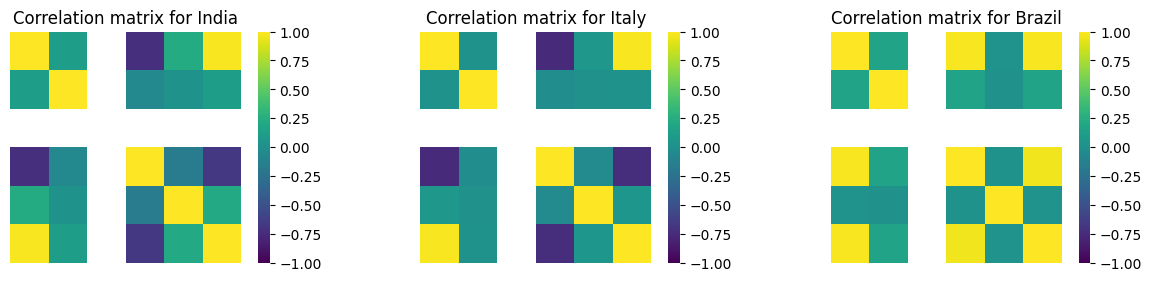

In [44]:
countries = ['India', 'Italy', 'Brazil']
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for idx, country in enumerate(countries):
    locked = df.loc[df['Area'] == country]
    locked_corr = locked.corr(numeric_only=True)
    sns.heatmap(locked_corr, center=0, square=True, cmap='viridis',
                vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=axs[idx])
    axs[idx].set_title(f'Correlation matrix for {country}')
plt.show()

We see overall that:
- numeric values are not tightly correlated to each other.
- More correlation can be observed between temperature and rainfall
- Yield appears to be independent to other parameters
- Time has a positive correlation with pesticide use

For specific types of crops we see that:
- Each item presents more correlation with the various variables but in a unique way for each crop item
- If for potatoes and maize there is negative correlation with rainfall, for cassava there is a positive one
- These different behaviors are not extreme and are averaged over the various types resulting in almost no correlation (previous image)

For specific nations we see that:
- Once again different patterns and again nothing that requires intervention.

---
### Check for data quality issues

In [45]:
df.duplicated().sum()

np.int64(2310)

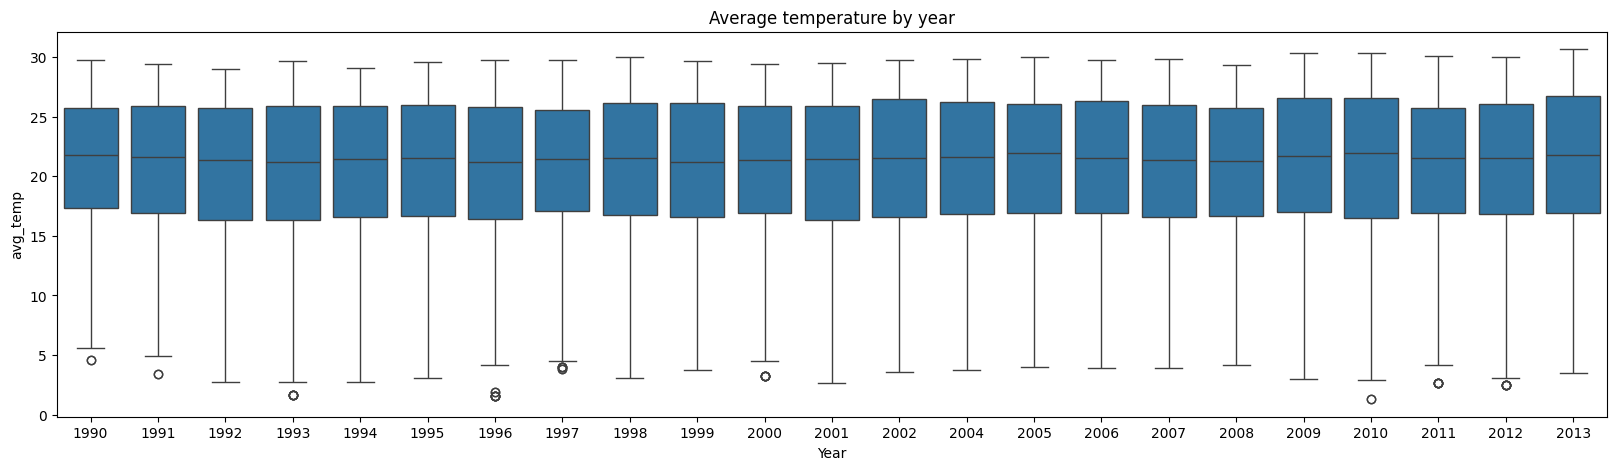

In [46]:
plt.figure(figsize=(20, 5))
sns.boxplot(df, x='Year', y='avg_temp')
plt.title('Average temperature by year')
plt.show()

We can observe 2310 duplicated rows. As the dataset has roughly 28000 rows we can drop these without expecting significant drop of efficiency.

As for numerical columns, we can ignore the outliers in the `pesticides_tonnes` column as we will drop it: the model will not take into account pesticide use as the application won't ask the user whether pesticides will be used on the fields, also to discourage excessive use of pesticides.  
For outliers in `avg_temp` we don't really need to worry as they could represent some extremely cold or hot year respect to the average, but don't present data significantly outised the '_normal_' range (_for some countries at least_).

---
### Yield analysis
As the `hg/ha_yield` variable is numeric, it is not possible to scale it, since it is needed in prediction. Anyway there are some outliers for yield, mostly for unusual high values respect to the data present in the dataset. These are more frequent for the crop types '**Potatoes**', '**Wheat**' and '**Maize**' and could skew predictions towards higher values than reality.

---
## Conclusions
Overall the dataset needs minimal preprocessing:
- scaling of the numerical values
- conversion of categorical variables into numerical ones
- removal of 'undesired' columns: `Year` and `pesticides_tonnes`.